# In this notebook we will look at the effects of place fields when stretching the environment (as in John Kubie's).
### We suggest that LEC cells are the main drive of such phenomena. At least 2 things could happen: 1) LEC cells stretch their firing fields and consequently place fields are stretched, or 2) LEC cells generate new place fields. We will test both options.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras as keras

from scipy.ndimage.filters import gaussian_filter

In [2]:
def G_rate_map(arena_size=[100,100], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    
    ## Normalize if for learning and LEC integration effiency 
    if G.min()<0: G += abs(G.min())
    G = (G - G.min())/(G.max()-G.min())
        
    return G

In [3]:
def LEC_rate_map(arena_size=[100,100], filled_perc=0.3):
    
    '''
    Build 'sort of' LEC cells. See Renno-Costa et al. 2010
    These cells have X (filled_perc) number of firing fields randomly spread over the arena
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        filled_perc (float)       : define how much area this cell is receptive to (value from 0 to 1).
    '''
    
    a = np.zeros(36)
    a[: int(filled_perc*25) ] = 1
    np.random.shuffle(a)
    a = a.reshape(6,6)
    
    b = np.zeros((arena_size[0], arena_size[1]))
    
    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            idx1 = i * len(a) / arena_size[0]
            idx2 = j * len(a) / arena_size[1]
            b[i][j] = a[idx1][idx2]

    arena = scipy.ndimage.filters.gaussian_filter(b, 4)
    arena *= 0.6
    
    return arena

In [4]:
n_grid = 70
n_lec = 230

arena_size = [50,50]

grid_lamb, grid_phase = [],[]  # this will be used to generate grid cells on the reshaped version of the environment


grid_data = []
for ii in range(n_grid):
    lamb  = np.random.randint(500,2000)
    phase = np.random.randint(0,arena_size[0],2)  ## This is assuming arena is a square
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data.append( g.flatten()  )
    
    grid_lamb.append(lamb)
    grid_phase.append(phase)
    
grid_data = np.array(grid_data)


lec_1_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_1_data.append( l.flatten()  )
lec_1_data = np.array(lec_1_data)

In [5]:
# Make data structure combining both MEC and LEC_1
data = np.vstack((grid_data , lec_1_data))
data = data.T

# Build the model

In [13]:
neurons_softmax = 50

model = keras.Sequential([
keras.layers.Dense(200, activation=tf.nn.relu, input_shape=(data.shape[1],)  ),
# keras.layers.Dense(100, activation=tf.nn.relu ),
keras.layers.Dense(100, activation=tf.nn.relu, name='DG'),
keras.layers.Softmax( name='DG_softmax' ),
keras.layers.Dense(50, activation=tf.nn.relu, name='CA3'),
keras.layers.Softmax(  name='CA3_softmax' ),
keras.layers.Dense(200, activation=tf.nn.relu, name='CA1'),
keras.layers.Dense(data.shape[1])
])

optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
DG (Dense)                   (None, 100)               20100     
_________________________________________________________________
DG_softmax (Softmax)         (None, 100)               0         
_________________________________________________________________
CA3 (Dense)                  (None, 50)                5050      
_________________________________________________________________
CA3_softmax (Softmax)        (None, 50)                0         
_________________________________________________________________
CA1 (Dense)                  (None, 200)               10200     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
Total para

In [15]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

In [16]:
EPOCHS = 1000
# history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='auto', baseline=0.02 )] )      
history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0 )      

# f_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=0, mode='auto', baseline=None)

# history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[f_cb])


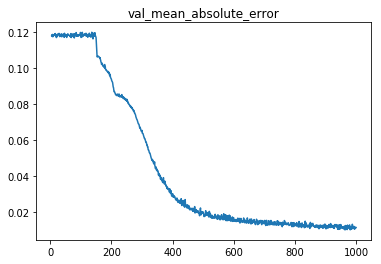

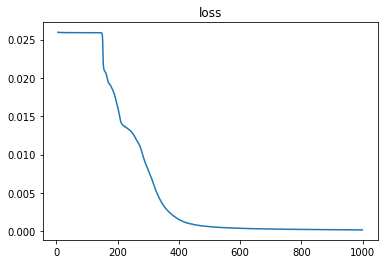

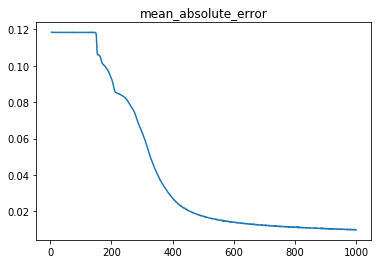

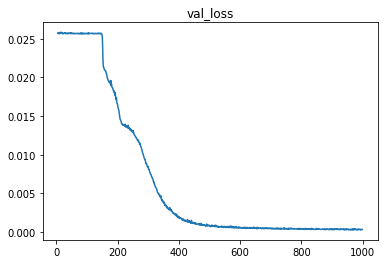

In [17]:
for kk in history.history.keys():
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    plt.show()

# test place fields in reshaped environment

In [18]:
n_grid = 70
n_lec = 230

arena_size = [50,100]

grid_data_new = []
for ii in range(n_grid):
    lamb  = grid_lamb[ii]
    phase = grid_phase[ii]
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data_new.append( g.flatten()  )
grid_data_new = np.array(grid_data_new)


############################################################################################################
# Data 1 : Stretch LEC fields
lec_new_1_data = []
for ii in range(n_lec):
    l = np.repeat(lec_1_data[ii].reshape(50,50), 2, axis=1)  # Get back the original rate map and stretch it
    lec_new_1_data.append(l.flatten())
lec_new_1_data = np.array(lec_new_1_data)

# Make data structure combining both MEC and LEC_1
data_1 = np.vstack((grid_data_new , lec_new_1_data))
data_1 = data_1.T


############################################################################################################
# Data 2 : Add firing fields to LEC rate maps
lec_new_2_data = []
for ii in range(n_lec):
    l     = LEC_rate_map(arena_size=[50,50], filled_perc=0.2)
    old_l = lec_1_data[ii].reshape(50,50)
    this_l = np.hstack((old_l,l))    
    lec_new_2_data.append( this_l.flatten()  )
lec_new_2_data = np.array(lec_new_2_data)


# Make data structure combining both MEC and LEC_1
data_2 = np.vstack((grid_data_new , lec_new_2_data))
data_2 = data_2.T

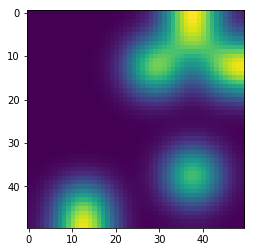

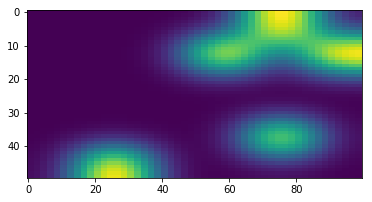

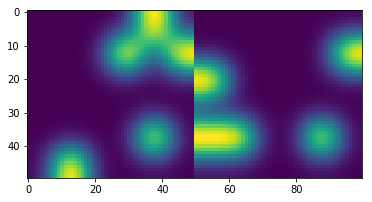

In [19]:
ii = 2
plt.imshow(lec_1_data[ii].reshape(50,50))
plt.show()

plt.imshow(lec_new_1_data[ii].reshape(50,100))
plt.show()

plt.imshow(lec_new_2_data[ii].reshape(50,100))
plt.show()

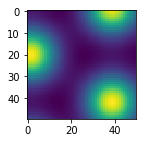

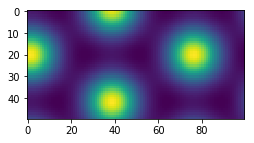

In [21]:
ii = 1

plt.figure(figsize=(2,2))
plt.imshow(grid_data[ii].reshape(50,50))

plt.figure(figsize=(4,2))
plt.imshow(grid_data_new[ii].reshape(50,100))

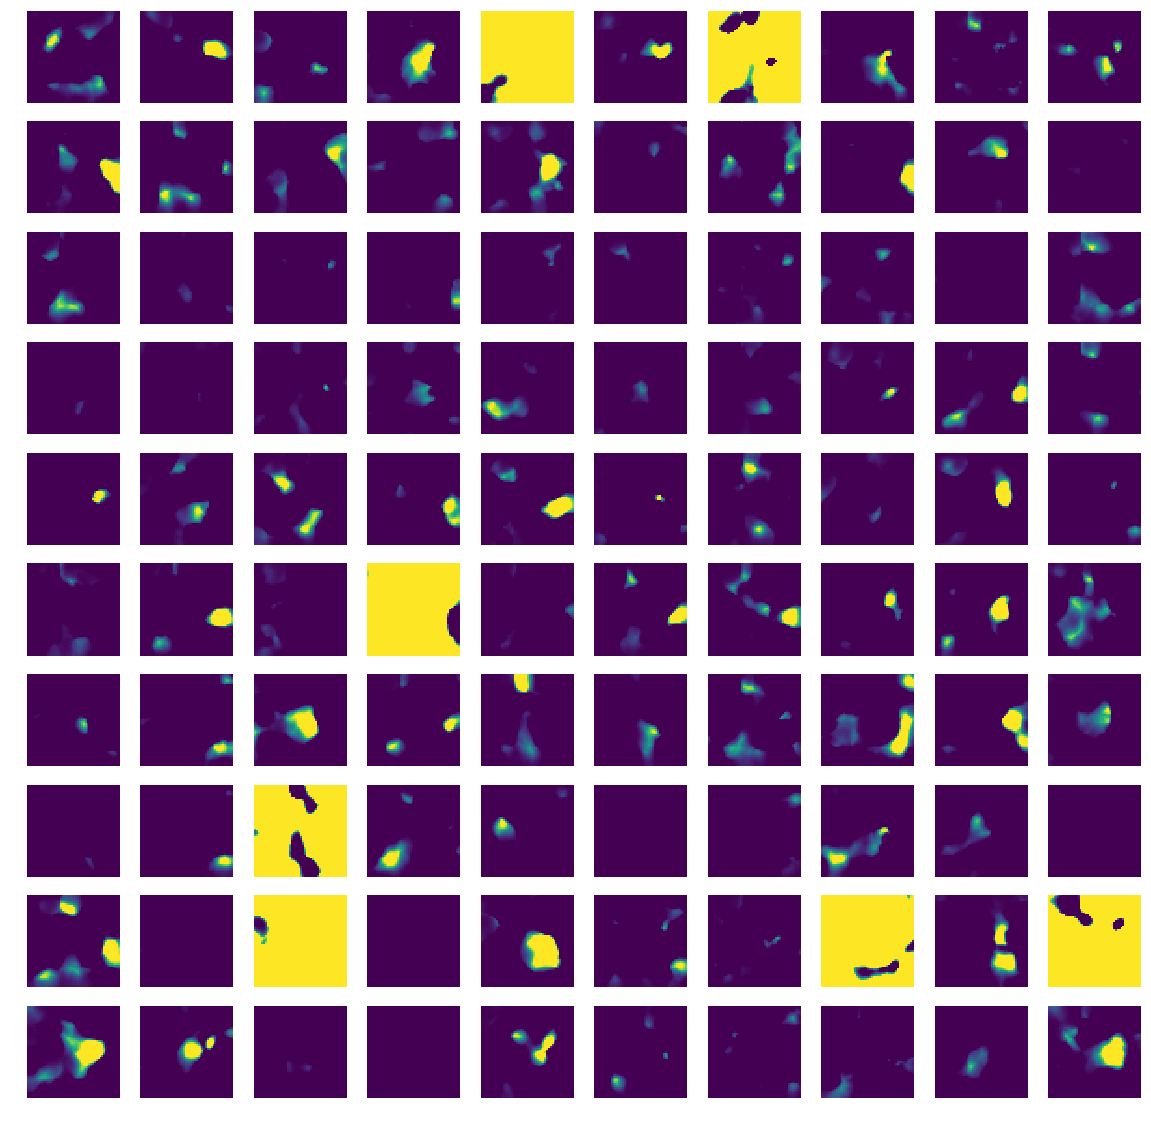

In [40]:
# layer_name = 'DG_softmax'
# units = 100

# heatmaps_dg_softmax = np.zeros((units,50,50)) # activations from neurons in SoftMax layer for the whole 50x50 arena
# m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
# for pos in range(data.shape[0]):                  # go through the whole arena
#     out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
#     heatmaps_dg_softmax[:, pos/50, pos%50] += out.ravel()    # save the outputs


    
# heatmaps_dg_softmax -= heatmaps_dg_softmax.min(axis=0)
# heatmaps_dg_softmax /=  heatmaps_dg_softmax.max(axis=0)
    
plt.figure(figsize=(20,20))
for ii in range(heatmaps_dg_softmax.shape[0]):
    plt.subplot(10,10,ii+1)
    plt.imshow(heatmaps_dg_softmax[ii])
    plt.clim(0,.001)
    plt.axis('off')    

0.011758854917388904

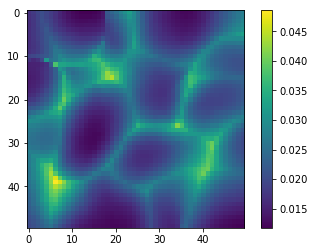

In [43]:
plt.imshow(np.mean(heatmaps_dg_softmax,axis=0))
plt.colorbar()

In [48]:
layer_name = 'DG_softmax'
units = 100

heatmaps = np.zeros((units,50,50)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
    heatmaps[:, pos/50, pos%50] += out.ravel()    # save the outputs



heatmaps_1 = np.zeros((units,50,100)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data_1.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data_1[pos]]))       # activate network and get SoftMax outputs
    heatmaps_1[:, pos/100, pos%100] += out.ravel()    # save the outputs
    
    

heatmaps_2 = np.zeros((units,50,100)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data_2.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data_2[pos]]))       # activate network and get SoftMax outputs
    heatmaps_2[:, pos/100, pos%100] += out.ravel()    # save the outputs    

In [49]:
counter = 1
plt.figure(figsize=(30,500))
for ii in range(heatmaps.shape[0]):
# for ii in range(20):

    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps[ii])    
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_1[ii])
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_2[ii])
#     plt.axis('off')
    counter += 1
    
plt.tight_layout()

# plt.savefig('lec_morph.pdf')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


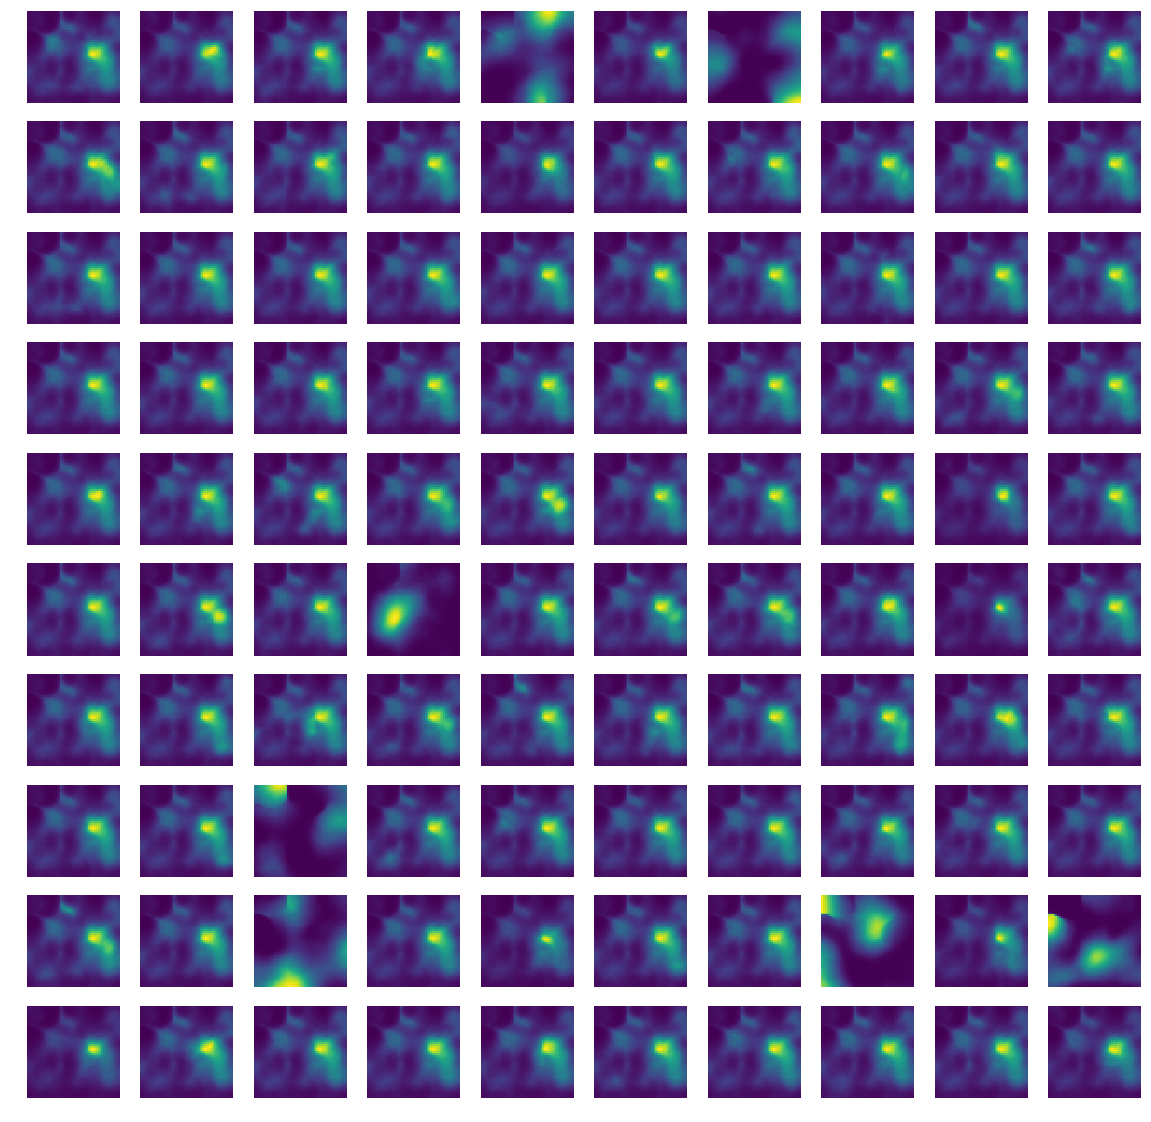

In [62]:
plt.figure(figsize=(20,20))
for ii in range(heatmaps.shape[0]):
    plt.subplot(10,10,ii+1)
    plt.imshow(heatmaps[ii])
    plt.axis('off')

# Quantify place fields number, displacement, etc

In [50]:
def get_number_of_place_fields(ratemap):
    
    gauss_kernel_sigma      = 2.  # px
    active_pixels_threshold = .2 # 20 percent
    cluster_min             = 100#200/3
    cluster_max             = 1000
    
    
#     ratemap = gaussian_filter( ratemap , gauss_kernel_sigma)

    
#     ratemap = (ratemap - ratemap.min()) / ratemap.max()
#     ratemap[ ratemap <  active_pixels_threshold ] = 0
#     ratemap[ ratemap >= active_pixels_threshold ] = 1



    
    ratemap = ratemap-ratemap.min()
    ratemap /= ratemap.max()
        
#     tmp[tmp<active_pixels_threshold] = 0
#     tmp[tmp>=active_pixels_threshold] = 1
    
#     mmmax = ratemap.max()


#     ratemap[ ratemap <  mmmax*active_pixels_threshold ] = 0
#     ratemap[ ratemap >= mmmax*active_pixels_threshold ] = 1


    visited_matrix  = np.zeros_like(ratemap)


    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

    visited_matrix  = np.zeros_like(ratemap)




    ## First pass of clustering
    clusterd_matrix = np.zeros_like(ratemap)
    current_cluster = 1

    #go through every bin in the ratemap
    for yy in range(1,ratemap.shape[0]-1):
        for xx in range(1,ratemap.shape[1]-1):

            if ratemap[  yy, xx ] == 1:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

                if clusterd_matrix[ yy, xx ] == 0:
                    current_cluster += 1
                    clusterd_matrix[ yy, xx ] = current_cluster



    ## Refine clustering: neighbour bins to same cluster number
    for yy in range(1,clusterd_matrix.shape[0]-1):
        for xx in range(1,clusterd_matrix.shape[1]-1):


            if clusterd_matrix[  yy, xx ] != 0:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                                clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]







    ## Quantify number of place fields
    clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

    n_place_fields_counter = 0
    
    place_fields_properties = {}

    

    for k in range(clusters_labels.size):

        n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size
        
        kluster_index = np.where(clusterd_matrix == clusters_labels[k] )


        if cluster_min <= n_bins <= cluster_max:
            
            
            place_field_center_of_mass = np.mean( kluster_index[0] +1j* kluster_index[1])
            
            place_fields_properties[n_place_fields_counter] = {}
            place_fields_properties[n_place_fields_counter]['size'] = n_bins
            place_fields_properties[n_place_fields_counter]['place_field_center_of_mass'] = place_field_center_of_mass
            

            n_place_fields_counter += 1
            

    return place_fields_properties,clusterd_matrix

In [51]:
p_f_prop = {}
p_f_prop['original']  = []
p_f_prop['stretched'] = []

cluster_matrix = {}
cluster_matrix['original']  = []
cluster_matrix['stretched'] = []


for ii in range(len(heatmaps_1)):
    
    p_f_prop_ori,tmp_clusterd_matrix_ori = get_number_of_place_fields(heatmaps[ii])
    p_f_prop_stre,tmp_clusterd_matrix_stre = get_number_of_place_fields(heatmaps_1[ii])

    
    p_f_prop['original'].append( p_f_prop_ori )
    p_f_prop['stretched'].append( p_f_prop_stre  )
    
    cluster_matrix['original'].append( tmp_clusterd_matrix_ori )
    cluster_matrix['stretched'].append( tmp_clusterd_matrix_stre  )

In [52]:
n_pf_original = []
n_pf_streched = []

for cell_n in range(len(p_f_prop['original'])):

    n_pf_original.append( len(p_f_prop['original'][cell_n].keys()) )
    n_pf_streched.append( len(p_f_prop['stretched'][cell_n].keys()) )

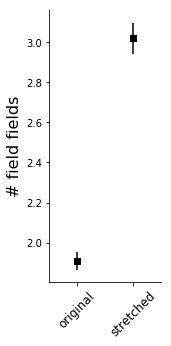

In [53]:
# plt.boxplot([n_pf_original,n_pf_streched], sym='');

fig, ax = plt.subplots(figsize=(2,5))
plt.errorbar( 0, np.nanmean(n_pf_original), yerr=stats.sem(n_pf_original, nan_policy='omit'), marker='s', color='k') 
plt.errorbar( 1, np.nanmean(n_pf_streched), yerr=stats.sem(n_pf_streched, nan_policy='omit'), marker='s', color='k') 
plt.xlim(-.5,1.5)
plt.xticks([0,1], ['original', 'stretched'], rotation=45, fontsize=12)

plt.ylabel('# field fields',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [54]:
delta_c_o_mass = []
delta_angle = []
delta_abs = []


for cell_n in range(len(p_f_prop['original'])):

    for o_pf_n in range(len(p_f_prop['original'][cell_n])):
        
        for s_pf_n in range(len(p_f_prop['stretched'][cell_n])):
            tmp_delta_c_o_mass = p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass']
            tmp_angle = np.angle(p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass'])
            tmp_abs = np.abs(p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass'])
        
            if abs(tmp_delta_c_o_mass.real) < 20:
                delta_c_o_mass.append(tmp_delta_c_o_mass.real)
                delta_angle.append(tmp_angle)
                delta_abs.append( tmp_abs )
                
delta_abs = np.array(delta_abs)
delta_angle = np.array(delta_angle)
delta_c_o_mass = np.array(delta_c_o_mass)

Text(0.5,1,'Place field center of mass \n shift horizontal axis (pixels)')

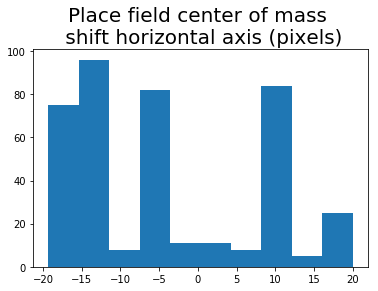

In [55]:
plt.hist(delta_c_o_mass);
# plt.xlim(-16,16)
plt.title('Place field center of mass \n shift horizontal axis (pixels)', fontsize=20)

Text(0.5,1.1,'Angular displacement')

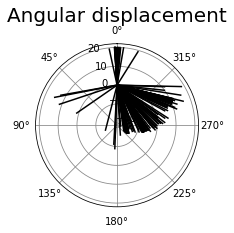

In [56]:
fig = plt.figure(figsize=(3, 3))  # Size
ax = plt.subplot(111, polar=True)  # Create subplot
plt.grid(color='#888888')  # Color the grid
ax.set_theta_zero_location('N')  # Set zero to North

for w in range(len(delta_angle)):
    ax.plot((0, delta_angle[w]), ( 0, delta_c_o_mass[w]), c='k' )
    
plt.title('Angular displacement', fontsize=20, y=1.1)

Text(0.5,1,'Place field center of mass \n shift both axis (pixels)')

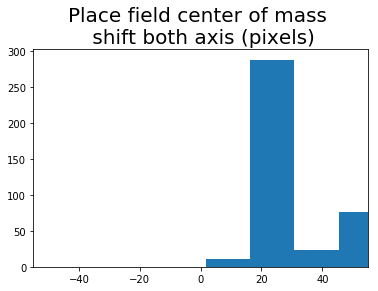

In [57]:
plt.hist(delta_abs,6);
plt.xlim(-55,55)
plt.title('Place field center of mass \n shift both axis (pixels)', fontsize=20)

In [ ]:
p_f_prop['original'][cell_n][pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][pf_n]['place_field_center_of_mass']
cell_n = 0
p_f_prop['original'][cell_n]

In [58]:
orig_field_size = []
stre_field_size = []

for cell_n in range(len(p_f_prop['original'])):

    tmp_size = []
    for o_pf_n in range(len(p_f_prop['original'][cell_n])):
        tmp_size.append(  p_f_prop['original'][cell_n][o_pf_n]['size']  )    
    orig_field_size.append( np.mean(tmp_size) )
        
    tmp_size = []
    for s_pf_n in range(len(p_f_prop['stretched'][cell_n])):
        tmp_size.append(  p_f_prop['stretched'][cell_n][s_pf_n]['size']  )    
    stre_field_size.append( np.mean(tmp_size) )            

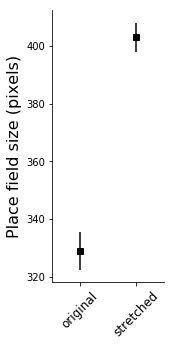

In [59]:
fig, ax = plt.subplots(figsize=(2,5))
plt.errorbar( 0, np.nanmean(orig_field_size), yerr=stats.sem(orig_field_size, nan_policy='omit'), marker='s', color='k') 
plt.errorbar( 1, np.nanmean(stre_field_size), yerr=stats.sem(stre_field_size, nan_policy='omit'), marker='s', color='k') 
plt.xlim(-.5,1.5)
plt.xticks([0,1], ['original', 'stretched'], rotation=45, fontsize=12)

plt.ylabel('Place field size (pixels)',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Do place fields occupy the arena uniformly?

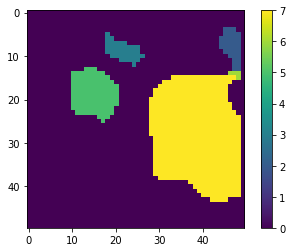

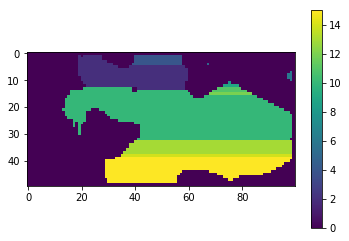

In [61]:
plt.imshow(np.nanmedian(np.array(cluster_matrix['original']), axis=0 ))
plt.colorbar()
plt.show()
plt.imshow(np.nanmedian(np.array(cluster_matrix['stretched']), axis=0 ))
plt.colorbar()
plt.show()